# 🔢 ML Workshop - Training on MNIST

**Author:** Shuvam Banerji Seal

This notebook covers:
- Loading and exploring MNIST dataset
- Building a neural network with PyTorch
- Training loop implementation
- Evaluation and visualization of results

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Set style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 8)

# Colors
CYAN = '#00d9ff'
PINK = '#ff6b9d'
YELLOW = '#c8ff00'
GREEN = '#00ff88'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

🖥️  Using device: cpu


## 1. Load MNIST Dataset

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n📊 MNIST Dataset:")
print(f"   Training samples: {len(train_dataset):,}")
print(f"   Test samples: {len(test_dataset):,}")
print(f"   Image size: 28 × 28 (784 pixels)")
print(f"   Classes: 0-9 (10 digits)")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")


📊 MNIST Dataset:
   Training samples: 60,000
   Test samples: 10,000
   Image size: 28 × 28 (784 pixels)
   Classes: 0-9 (10 digits)
   Batch size: 64
   Training batches: 938


## 2. Explore the Data

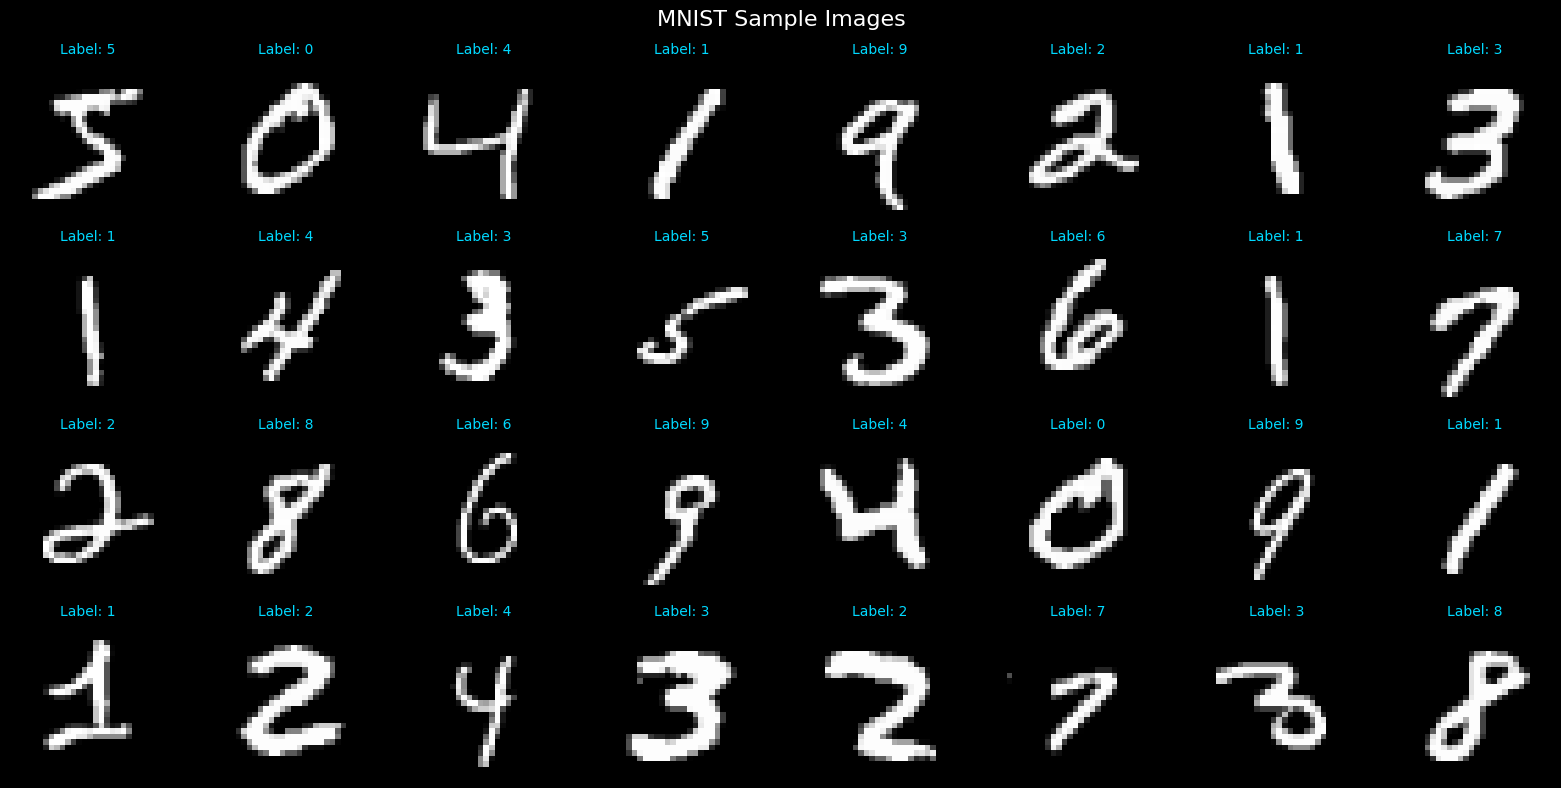

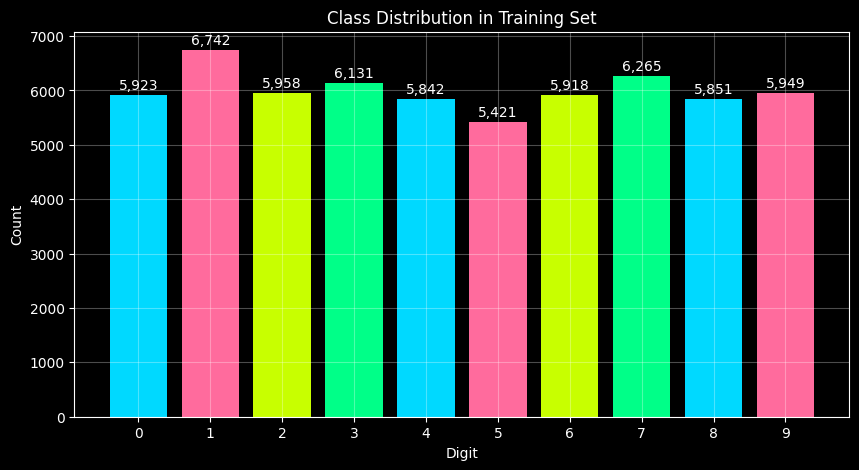

In [3]:
# Visualize some samples
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i, ax in enumerate(axes.flatten()):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}', fontsize=10, color=CYAN)
    ax.axis('off')

plt.suptitle('MNIST Sample Images', fontsize=16)
plt.tight_layout()
plt.show()

# Show class distribution
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
unique, counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(unique, counts, color=[CYAN, PINK, YELLOW, GREEN, CYAN, PINK, YELLOW, GREEN, CYAN, PINK])
ax.set_xlabel('Digit')
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Training Set')
ax.set_xticks(range(10))
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}', ha='center', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## 3. Define Neural Network Models

In [4]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for MNIST classification.
    """
    def __init__(self, hidden_sizes=[256, 128], dropout_rate=0.2):
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        layers = []
        prev_size = 784  # 28 * 28
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 10))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)


class CNN(nn.Module):
    """
    Convolutional Neural Network for MNIST.
    """
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Conv Block 1: 28x28 -> 14x14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 2: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


# Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Create models
mlp = MLP().to(device)
cnn = CNN().to(device)

print("\n🧠 Model Comparison:")
print(f"   MLP Parameters: {count_params(mlp):,}")
print(f"   CNN Parameters: {count_params(cnn):,}")


🧠 Model Comparison:
   MLP Parameters: 235,146
   CNN Parameters: 421,834


## 4. Training Functions

In [5]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """
    Evaluate model.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    """
    Full training loop.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in tqdm(range(epochs), desc='Training'):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step(test_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return history

## 5. Train MLP

In [6]:
print("\n" + "="*60)
print("Training MLP")
print("="*60)

mlp = MLP().to(device)
mlp_history = train_model(mlp, train_loader, test_loader, epochs=10, lr=0.001)


Training MLP


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  1: Train Loss=0.2776, Train Acc=0.9150, Test Loss=0.1222, Test Acc=0.9619
Epoch  2: Train Loss=0.1302, Train Acc=0.9610, Test Loss=0.0949, Test Acc=0.9713
Epoch  3: Train Loss=0.0990, Train Acc=0.9700, Test Loss=0.0848, Test Acc=0.9747
Epoch  4: Train Loss=0.0832, Train Acc=0.9738, Test Loss=0.0730, Test Acc=0.9779
Epoch  5: Train Loss=0.0717, Train Acc=0.9776, Test Loss=0.0767, Test Acc=0.9769
Epoch  6: Train Loss=0.0640, Train Acc=0.9795, Test Loss=0.0745, Test Acc=0.9773
Epoch  7: Train Loss=0.0600, Train Acc=0.9813, Test Loss=0.0708, Test Acc=0.9786
Epoch  8: Train Loss=0.0533, Train Acc=0.9835, Test Loss=0.0730, Test Acc=0.9793
Epoch  9: Train Loss=0.0490, Train Acc=0.9842, Test Loss=0.0582, Test Acc=0.9830
Epoch 10: Train Loss=0.0476, Train Acc=0.9846, Test Loss=0.0678, Test Acc=0.9817


## 6. Train CNN

In [11]:
print("\n" + "="*60)
print("Training CNN")
print("="*60)

cnn = CNN().to(device)
cnn_history = train_model(cnn, train_loader, test_loader, epochs=10, lr=0.001)


Training CNN


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## 7. Visualize Training Results

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(mlp_history['train_loss']) + 1)

# MLP Loss
axes[0, 0].plot(epochs, mlp_history['train_loss'], color=CYAN, label='Train', linewidth=2)
axes[0, 0].plot(epochs, mlp_history['test_loss'], color=PINK, label='Test', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('MLP Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MLP Accuracy
axes[0, 1].plot(epochs, mlp_history['train_acc'], color=CYAN, label='Train', linewidth=2)
axes[0, 1].plot(epochs, mlp_history['test_acc'], color=PINK, label='Test', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('MLP Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.8, 1.0])

# CNN Loss
axes[1, 0].plot(epochs, cnn_history['train_loss'], color=CYAN, label='Train', linewidth=2)
axes[1, 0].plot(epochs, cnn_history['test_loss'], color=PINK, label='Test', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('CNN Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# CNN Accuracy
axes[1, 1].plot(epochs, cnn_history['train_acc'], color=CYAN, label='Train', linewidth=2)
axes[1, 1].plot(epochs, cnn_history['test_acc'], color=PINK, label='Test', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('CNN Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0.8, 1.0])

plt.suptitle('Training Progress: MLP vs CNN', fontsize=16)
plt.tight_layout()
plt.show()

# Print final results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"MLP Test Accuracy:  {mlp_history['test_acc'][-1]*100:.2f}%")
print(f"CNN Test Accuracy:  {cnn_history['test_acc'][-1]*100:.2f}%")

## 8. Visualize Predictions

In [ ]:
@torch.no_grad()
def visualize_predictions(model, loader, n_samples=24, model_name='Model'):
    """
    Visualize model predictions.
    """
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:n_samples], labels[:n_samples]
    
    outputs = model(images.to(device))
    _, predictions = outputs.max(1)
    predictions = predictions.cpu()
    
    # Calculate grid size
    n_cols = 6
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.5))
    
    for i, ax in enumerate(axes.flatten()):
        if i < n_samples:
            img = images[i].squeeze().numpy()
            pred = predictions[i].item()
            true = labels[i].item()
            
            ax.imshow(img, cmap='gray')
            
            color = GREEN if pred == true else 'red'
            title = f'Pred: {pred}\nTrue: {true}'
            ax.set_title(title, color=color, fontsize=11)
        ax.axis('off')
    
    plt.suptitle(f'{model_name} Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_predictions(cnn, test_loader, n_samples=24, model_name='CNN')

## 9. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

@torch.no_grad()
def get_all_predictions(model, loader, device):
    """Get all predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        outputs = model(images.to(device))
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)


# Get predictions
cnn_preds, cnn_labels = get_all_predictions(cnn, test_loader, device)

# Compute confusion matrix
cm = confusion_matrix(cnn_labels, cnn_preds)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=ax,
            xticklabels=range(10), yticklabels=range(10))
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CNN Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📊 Per-class Accuracy:")
for i in range(10):
    mask = cnn_labels == i
    acc = (cnn_preds[mask] == i).mean() * 100
    print(f"   Digit {i}: {acc:.1f}%")

## 10. Visualize Misclassifications

In [ ]:
# Find misclassified samples
misclassified_idx = np.where(cnn_preds != cnn_labels)[0]
print(f"\n❌ Total misclassified: {len(misclassified_idx)} / {len(cnn_labels)}")
print(f"   Error rate: {len(misclassified_idx)/len(cnn_labels)*100:.2f}%")

# Visualize some misclassifications
n_show = min(20, len(misclassified_idx))
fig, axes = plt.subplots(4, 5, figsize=(14, 12))

# Get images directly from test_dataset
for i, ax in enumerate(axes.flatten()):
    if i < n_show:
        idx = misclassified_idx[i]
        img, true_label = test_dataset[idx]
        pred_label = cnn_preds[idx]
        
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', color='red', fontsize=11)
    ax.axis('off')

plt.suptitle('Misclassified Images (These are genuinely hard!)', fontsize=16)
plt.tight_layout()
plt.show()

## 📝 Summary

In this notebook, we:

1. **Loaded MNIST** with proper normalization
2. **Built two models**: MLP and CNN in PyTorch
3. **Trained** both models with proper train/eval modes
4. **Evaluated** with confusion matrix and per-class metrics
5. **Analyzed** misclassifications

**Key Results:**
- MLP achieves ~98% accuracy
- CNN achieves ~99% accuracy
- CNNs are better for image data due to spatial structure preservation

**Next Steps:**
- Try data augmentation
- Experiment with different architectures
- Move to more challenging datasets (CIFAR-10, ImageNet)